# Processing Temperature

In [ ]:
# !pip install plotly==5.1.0
# !pip install "jupyterlab>=3" "ipywidgets>=7.6"

In [106]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import plotly.express as px
import plotly.graph_objects as go
pd.options.plotting.backend = "plotly"

import scipy.fftpack
from scipy.signal import butter, filtfilt, medfilt
from scipy.ndimage import uniform_filter1d
from scipy import signal
from scipy.signal import find_peaks
from scipy import interpolate
from scipy.signal.signaltools import detrend

### Datasets

In [98]:
# save data in dictionaries for easy looping
signal_data = {}
event_data = {}
flip={}

# Reading 1 
signal_data["M1"] = pd.read_csv('Data/m1.csv')
event_data["M1"] = [1623568142869, 1623568443999, 1623568623752]
flip["M1"] = False

# Reading 2
signal_data["A1"] = pd.read_csv('Data/a1.csv')
event_data["A1"] = [1623587249559, 1623587553231, 1623587733163]
flip["A1"]= True

# Reading 3 
signal_data["A2"] = pd.read_csv('Data/a2.csv')
event_data["A2"] = [1623571666140, 1623571966485, 1623572147235]
flip["A2"]= False

# Reading 4
signal_data["A3"] = pd.read_csv('Data/age52June242021.csv')
event_data["A3"] = [1624509304574, 1624509618657, 1624509783431]
flip["A3"]= False

# Reading 5
signal_data["T1"] = pd.read_csv('Data/age55June242021.csv')
event_data["T1"] = [1624510578929, 1624510877105, 1624511059168]
flip["T1"]= False

# Reading 6
signal_data["M2"] = pd.read_csv('Data/age23June262021.csv')
event_data["M2"] = [1624723469219, 1624723768744, 1624723768923]
flip["M2"]= True

# Reading 7
signal_data["A4"] = pd.read_csv('Data/age52June272021.csv')
event_data["A4"] = [1624803269155, 1624803569284, 1624803749742]
flip["A4"]= True

# Reading 8
signal_data["N1"] = pd.read_csv('Data/age20June272021.csv')
event_data["N1"]  = [1624810203138, 1624810504150, 1624810697546]
flip["N1"]= True

# Reading 9
signal_data["M3"] = pd.read_csv('Data/age23June272021.csv')
event_data["M3"] = [1624812157099, 1624812463834, 1624812648001]
flip["M3"]= True

# Reading 10
signal_data["M4"] = pd.read_csv('Data/age23June292021withCold.csv')
event_data["M4"] = [1624975875204, 1624976180767, 1624976356073]
flip["M4"]= True

# Reading 11
signal_data["A5"] = pd.read_csv('Data/age52June292021.csv')
event_data["A5"] = [1624981671112, 1624981982342 , 1624982157453]
flip["A5"]= True

# Reading 12
signal_data["N2"] = pd.read_csv('Data/age20June292021.csv')
event_data["N2"] = [1624983536426, 1624983837325, 1624984023832]
flip["N2"]= True

# Reading 13
signal_data["T2"] = pd.read_csv('Data/age55July032021.csv')
event_data["T2"] = [1625282721122, 1625283023666, 1625283203210]
flip["T2"]= True

# Reading 12
signal_data["N3"] = pd.read_csv('Data/age20July032021.csv')
event_data["N3"] = [1625285355125, 1625285667437, 1625285836317]
flip["N3"]= True

### Proccecssing

In [118]:
S_fs = 100
P_fs = 100
T_fs = 10
I_fs = 20

def get_timePoints(data:pd.Series,timestamps:[int])->[int]:
    deviation = 100
    location = []
    for time in timestamps:
        try:
            match = data[(data>time-deviation)&(data<time+deviation)].index[0]
            location.append(match)
        except:
            print(f'Timestamp {time} not found in data')
    return location

In [141]:
def plot(data,timestamps, events=[]):
    fig = go.Figure(data=go.Scatter(x=timestamps,y=data))
    for event in events:
        fig.add_vline(x=event)
    fig.show()
    

In [66]:
def clean_data(data, max_val=2*64, min_val=-2*64):
    # Accepts a numpy array, remove nan and return values in range. Replace outliers with mean
    data_without_nan = data[~np.isnan(data)] #  FOR DF   data_without_nan = data.dropna()
    mean_val = np.mean(data_without_nan)
    data_without_nan[data_without_nan > max_val] = mean_val
    data_without_nan[data_without_nan < min_val] = mean_val
    return data_without_nan

def replace_nan(data, replace_with):
    data[np.isnan(data)] = replace_with
    return data

In [50]:
def calculate_slope(data, start, stop):
    selected = data[start:stop]
    time = np.array(range(start, stop))/T_fs
    nCs = len(selected)
    slope = (nCs*np.sum(selected*time)-(np.sum(selected)*sum(time)))/(nCs*np.sum(time*time)-(np.sum(time))**2)
    return slope

def get_lowest(data):
    min_vals = np.where(data == data.min())[0]
    try:
        min_val = min_vals[0]
        return min_val
    except:
        return 0
    
def long_term_indices(data, rising_seg_len=180, falling_seg_len=180):
    tmp_lowest = get_lowest(data)
    tmp_r_grad = calculate_slope(data,tmp_lowest,tmp_lowest+int(rising_seg_len*T_fs))
    tmp_f_grad = calculate_slope(data,tmp_lowest-int(falling_seg_len*T_fs),tmp_lowest)
    tmp_rise_fall = tmp_r_grad/tmp_f_grad
    return [tmp_r_grad, tmp_f_grad, tmp_rise_fall, data[tmp_lowest]]

def get_AUC(data, start, end):
    sig = data[start:end]
    sig = sig - min(sig)
    AUC = np.trapz(sig, dx=1/T_fs)
    return AUC

In [99]:
def ind_temp(data, flip, time_stamps):
    # Indices: TMP_rise, TMP_fall, TMP_rise/fall, TMP_base, TMP_AUC, TMP_env, TMP_max, TMP_min
    FILTER_LEN = 80
    if flip:
        TData = data.TCData
        TCData = data.TData
        Ttime = data.TCDatatime
    else:
        TData = data.TData
        TCData = data.TCData
        Ttime = data.TDatatime

    EData = replace_nan(data.EData,0)
    env_temp = np.mean(EData/100)
    time_points = get_timePoints(Ttime, time_stamps)

    tmp_data = (TData - TCData)/100   
#     tmp_data = (TData - EData) / 100
    last_ind = tmp_data.last_valid_index()
    tmp_data = np.array(tmp_data)
    
    #clean data
    tmp_data = clean_data(tmp_data, 10,-10)
#     tmp_data = clean_data(tmp_data, 42,30)
    tmp_time = clean_data(Ttime, max(Ttime), min(Ttime))
    
    
    # tmp_data = detrend_sig(baseline, tmp_data)
    filtered_temp = uniform_filter1d(tmp_data, size=FILTER_LEN)
    baseline = filtered_temp[time_points[0]:time_points[1]]
    avg_tmp = np.mean(baseline)
    max_tmp = max(tmp_data/100)
#     plot(filtered_temp,Ttime)

    tmp_ind = long_term_indices(filtered_temp, 60, 120)
    AUC = get_AUC(filtered_temp,time_points[0],time_points[0]+12*60) #check end

    tmp_ind.extend([avg_tmp, max_tmp, AUC])
    return tmp_ind

In [51]:
# dataA4 = pd.read_csv('Data/age52June272021.csv')
# time_stampsA4 = [1624803269155, 1624803569284, 1624803749742]
# TMP_indicesM1 = ind_temp(dataA4, True, time_stampsA4)

<ipython-input-66-38b2b21d9bff>:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



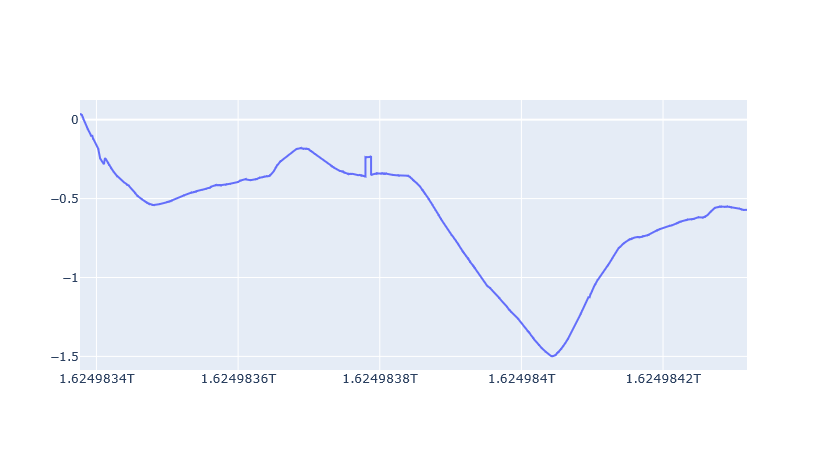

In [76]:
# EXAMPLE
subject = "N2"
TMP_indicesN = ind_temp(signal_data[subject], True, event_data[subject])

### Results

In [100]:
TMP_indices ={}
for subject in signal_data.keys():
    TMP_indices[subject] = ind_temp(signal_data[subject], flip[subject], event_data[subject])
    print(f'{subject} processed')
    
indices_df = pd.DataFrame.from_dict(TMP_indices).transpose()
indices_df.columns= ["TMP_rise", "TMP_fall", 'TMP_rise/fall', "TMP_min", "TMP_base", "TMP_max","TMP_AUC"  ]
indices_df

<ipython-input-66-38b2b21d9bff>:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



M1 processed
A1 processed
A2 processed
A3 processed
T1 processed
M2 processed
A4 processed
N1 processed
M3 processed
M4 processed
A5 processed
N2 processed
T2 processed
N3 processed


{'M1': [0.01272109724610375,
  -0.007484618409457088,
  -1.6996320386928716,
  -1.5831249999999968,
  -0.11587788331071888,
  0.0012,
  2.2143124999999904],
 'A1': [0.015402379520498458,
  -0.007069953377571713,
  -2.178568753983587,
  -1.1452500000000005,
  0.170321953072248,
  0.0039000000000000003,
  3.1551875000000225],
 'A2': [0.005482900716390537,
  -0.004507094718468477,
  -1.2165044355343926,
  -1.1593750000000012,
  -0.1440096394144944,
  0.0004,
  1.3008875],
 'A3': [0.01353542103589117,
  -0.008409334203530745,
  -1.6095710680886228,
  -1.1681249999999996,
  -0.04011608311518286,
  0.0015,
  2.32814374999998],
 'T1': [0.008256712935313808,
  -0.0028938484853114703,
  -2.8531946220484734,
  -0.6117499999999978,
  0.1908915013679898,
  0.0235,
  2.6633124999999946],
 'M2': [0.0051546032419534996,
  -0.002659321134945231,
  -1.9383154498411714,
  -0.04837500000000109,
  0.3799537997991301,
  0.0064,
  1.0013187500000098],
 'A4': [0.01053135637182325,
  -0.003954912251675383,
  

In [116]:
indices_df = pd.DataFrame.from_dict(TMP_indices).transpose()
indices_df.columns= ["TMP_rise", "TMP_fall", 'TMP_rise/fall', "TMP_min", "TMP_base", "TMP_max","TMP_AUC"  ]
indices_df

TMP_rise  TMP_fall  TMP_rise/fall   TMP_min  TMP_base  TMP_max    TMP_AUC
M1  0.012721 -0.007485      -1.699632 -1.583125 -0.115878   0.0012   2.214312
A1  0.015402 -0.007070      -2.178569 -1.145250  0.170322   0.0039   3.155188
A2  0.005483 -0.004507      -1.216504 -1.159375 -0.144010   0.0004   1.300887
A3  0.013535 -0.008409      -1.609571 -1.168125 -0.040116   0.0015   2.328144
T1  0.008257 -0.002894      -2.853195 -0.611750  0.190892   0.0235   2.663312
M2  0.005155 -0.002659      -1.938315 -0.048375  0.379954   0.0064   1.001319
A4  0.010531 -0.003955      -2.662855 -1.006625 -0.331557  -0.0016   3.652825
N1  0.019708 -0.007410      -2.659528 -0.904625  0.715183   0.0107  10.552994
M3  0.009889 -0.005658      -1.747766 -1.112625 -0.093424   0.0085   0.794069
M4  0.000256 -0.004792      -0.053336 -0.599500  0.192137   0.1000   5.957975
A5  0.001365 -0.001657      -0.823645 -0.731750 -0.126595   0.0959   3.796300
N2  0.007985 -0.005239      -1.524166 -1.500625 -0.330462   0.0944   3.112769
T2  0.005807 -0.003583      -1.620649 -0.885875 -0.374363   0.0939   2.516650
N3  0.005300 -0.003745      -1.415097 -0.689250  0.099083   0.0029   2.777831

In [110]:
def plot_df(df,labels):
    df["color"] = labels
    for i in df.columns[:-1]:
        fig = px.scatter(df, x=df.index, y=i, color="color")
        fig.show()

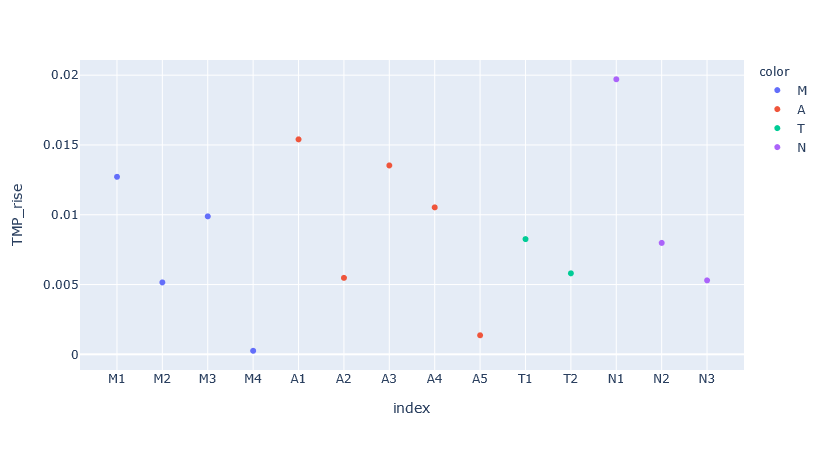

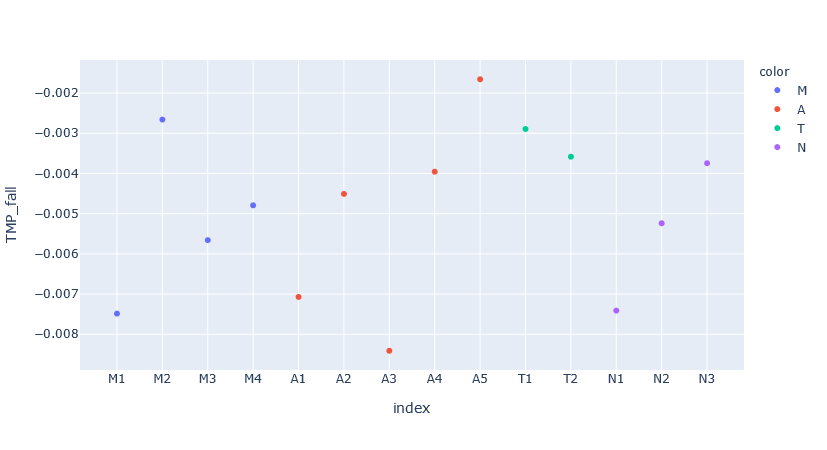

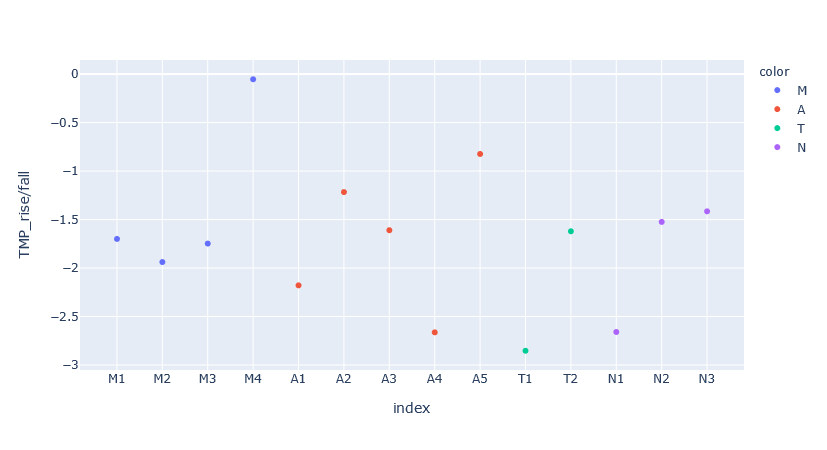

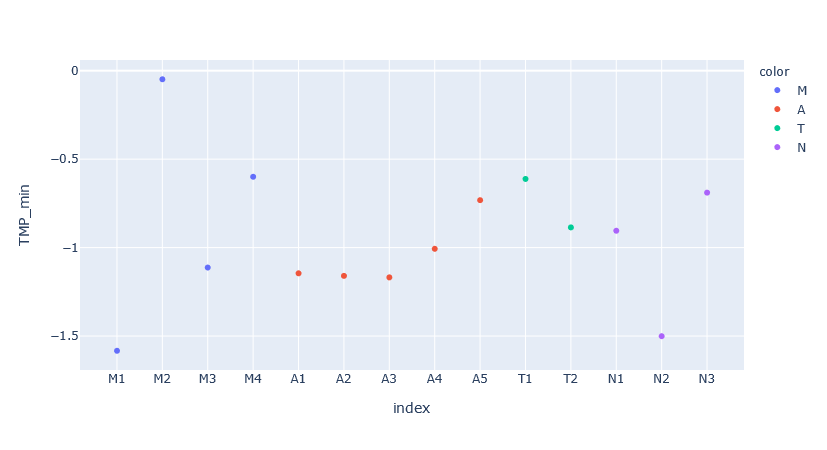

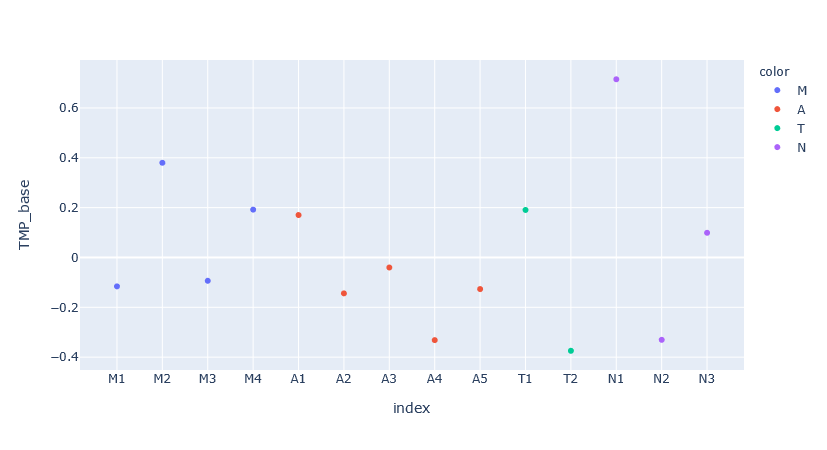

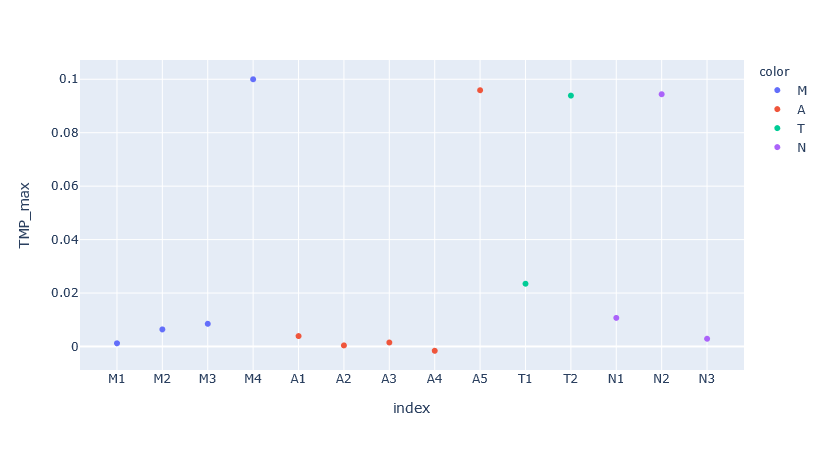

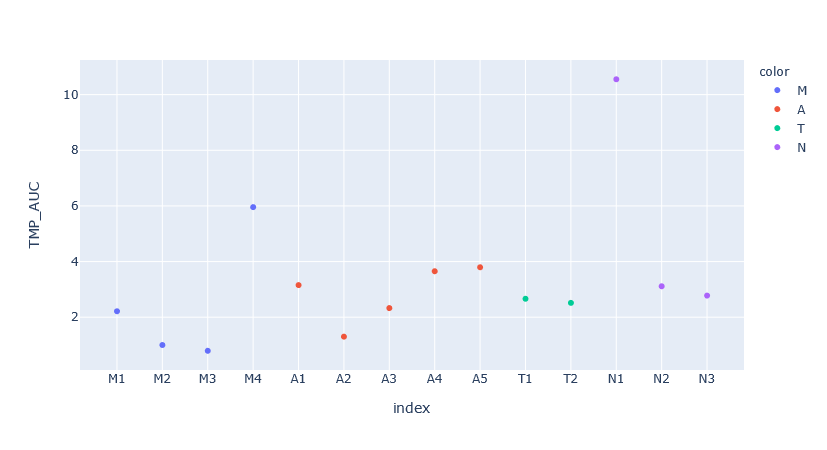

In [117]:
labels = [x[0] for x in signal_data.keys()]
plot_df(indices_df, labels)

# Impedance

In [133]:
def detrend_sig(baseline, sig):
    p = np.polyfit(range(1,len(baseline)+1),baseline,2) #check for 2
    z = np.polyval(p,range(1,len(sig)+1))
    
    return (sig-z)

In [155]:
FILT_ORDER = 100
def ind_imp(data, flip, time_stamps):
    # Indices: IMP_rise, IMP_fall, IMP_rise/fall, IMP_baseline, IMP_AUC
    WCData = data.WData
    WData = data.WCData
    Itime = data.WCDatatime
#     if flip:
#         WCData = data.WData
#         WData = data.WCData
#         Itime = data.WCDatatime
#     else:
#         WData = data.WData
#         WCData = data.WCData
#         Itime = data.WDatatime
    real = clean_data(WData, 66000, 55000)
    img = clean_data(WCData, 66000, 55000)
    time_points = get_timePoints(Itime, time_stamps)
    imp_data = np.power((np.power(real,2)+np.power(img,2)), 0.5)
#     imp_data = clean_data(imp_data, 66000, 0)

    baseline = imp_data[time_points[0]:time_points[1]]
    imp_data = detrend_sig(baseline, imp_data)
    plot(imp_data,Itime,time_stamps)

    filtered_imp = uniform_filter1d(imp_data, size=FILT_ORDER)

    imp_ind = long_term_indices(filtered_imp, 60, 120)
    AUC = get_AUC(filtered_imp,time_points[0],len(filtered_imp))

    # imp_ind.append(baseline)
    # imp_ind.append(AUC)
#     imp_ind = []
    return imp_ind

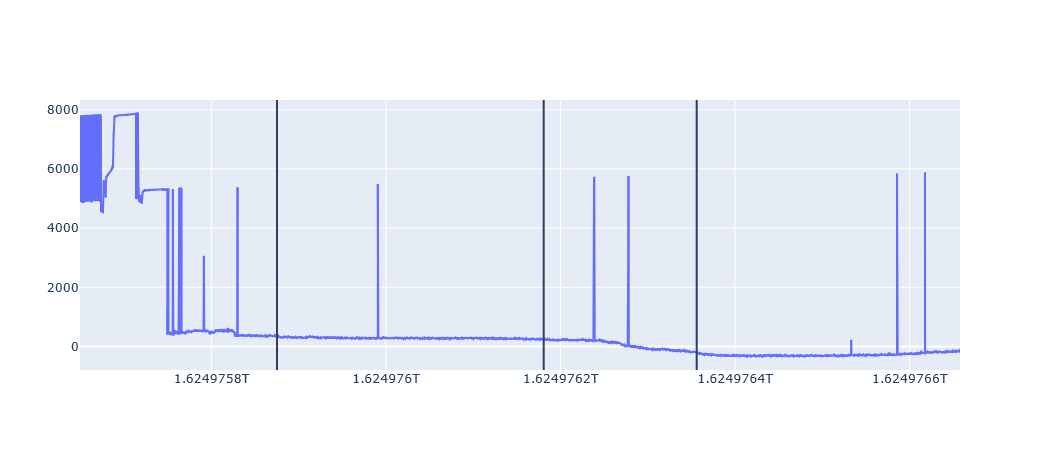

ValueError: operands could not be broadcast together with shapes (0,) (1200,) 

In [156]:
# EXAMPLE
subject = "M4"
IMP_indicesN = ind_imp(signal_data[subject], False, event_data[subject])
IMP_indicesN

In [121]:
IMP_indices ={}
for subject in signal_data.keys():
    IMP_indices[subject] = ind_imp(signal_data[subject], flip[subject], event_data[subject])
    print(f'{subject} processed')
    
indices_df = pd.DataFrame.from_dict(IMP_indices).transpose()
# indices_df.columns= ["TMP_rise", "TMP_fall", 'TMP_rise/fall', "TMP_min", "TMP_base", "TMP_max","TMP_AUC"  ]
indices_df

NameError: name 'remove_nan' is not defined